# Fit emimTF2N data

EoS: PR

Parameter T dependence: Linear in [R125, emimTF2N] direction

N (total fitting parameters): 3

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions import linear

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_subset = pd.read_csv('../r125_emimtf2n_subset.csv')

## Load Configuration + Load Original Parameters

In [3]:
params = pd.read_csv('Data/Fits/PR_params_3params_Opt1.csv',header=None)

In [4]:
params

,0
0,-0.051249
1,-0.062227
2,0.031433
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [5]:
# Take average of A, B (ij vs. ji) params, save
paramA_symm = (params.iloc[0] + params.iloc[1])/2
paramB_symm = (params.iloc[2] + params.iloc[3])/2

In [6]:
from hfc125_emimtf2n_PR import configuration 

In [7]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Apply Parameters + Plot

In [8]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

### Original Parameters

In [9]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa_A['R125','emimTf2N'] = params.iloc[0,0]
m.fs.properties.PR_kappa_A['emimTf2N','R125'] = params.iloc[1,0]
m.fs.properties.PR_kappa_B['R125','emimTf2N'] = params.iloc[2,0]
# m.fs.properties.PR_kappa_B['emimTf2N','R32'] = parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

#change to extended for actual model fit
R125_x = np.zeros((len(data_subset)))
P = np.zeros((len(data_subset)))
T = np.zeros((len(data_subset)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_subset)):
    print('i:',i)
    print('Try x_IL:',data_subset["x_emimTf2N"].iloc[i])
    m.fs.liq = data_subset["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_subset["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_subset["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data_subset["x_R125"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_subset["x_R125"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_subset["temperature"].iloc[i]))
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        
    except:
        print('Initialization Error')
        
    try:

        status = solver.solve(m, tee = False)
        
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print('Feasible/Optimal Solution')
            R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
            T[i] = data_subset["temperature"].iloc[i]
        else:
            print('Infeasible Solution')
            R125_x[i] = np.nan
            P[i] = np.nan
            T[i] = data_subset["temperature"].iloc[i]
            
    except ValueError:
        R125_x[i] = np.nan
        P[i] = np.nan
        T[i] = data_subset["temperature"].iloc[i]
        print('Solver Error')

i: 0
Try x_IL: 0.915
Feasible/Optimal Solution
i: 1
Try x_IL: 0.832
Feasible/Optimal Solution
i: 2
Try x_IL: 0.75
Feasible/Optimal Solution
i: 3
Try x_IL: 0.669
Feasible/Optimal Solution
i: 4
Try x_IL: 0.587
Feasible/Optimal Solution
i: 5
Try x_IL: 0.504
Feasible/Optimal Solution
i: 6
Try x_IL: 0.417
Feasible/Optimal Solution
i: 7
Try x_IL: 0.319
Feasible/Optimal Solution
i: 8
Try x_IL: 0.945
Feasible/Optimal Solution
i: 9
Try x_IL: 0.891
Feasible/Optimal Solution
i: 10
Try x_IL: 0.839
Feasible/Optimal Solution
i: 11
Try x_IL: 0.787
Feasible/Optimal Solution
i: 12
Try x_IL: 0.733
Feasible/Optimal Solution
i: 13
Try x_IL: 0.683
Feasible/Optimal Solution
i: 14
Try x_IL: 0.578
Feasible/Optimal Solution
i: 15
Try x_IL: 0.479
Feasible/Optimal Solution
i: 16
Try x_IL: 0.97
Feasible/Optimal Solution
i: 17
Try x_IL: 0.941
Feasible/Optimal Solution
i: 18
Try x_IL: 0.912
Feasible/Optimal Solution
i: 19
Try x_IL: 0.883
Feasible/Optimal Solution
i: 20
Try x_IL: 0.848
Feasible/Optimal Solution
i: 2

In [10]:
fitted_data = pd.DataFrame(data=[R125_x,P/1e6,T])
fitted_data = fitted_data.T
fitted_data.columns = ['R125_x','P, MPa','T, K']

In [11]:
error = (fitted_data['P, MPa']*1E6 - data_subset['pressure'])
error_squared = error**2
SSE = np.sum(error_squared)
# For scaling (per original setup)
SSE_sc = SSE*1E-9

In [12]:
SSE_sc

3.7636144754494913

In [27]:
SSE

3763614475.449491

### Symmetric Parameters

In [13]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa_A['R125','emimTf2N'] = paramA_symm[0]
m.fs.properties.PR_kappa_A['emimTf2N','R125'] = paramA_symm[0]
m.fs.properties.PR_kappa_B['R125','emimTf2N'] = paramB_symm[0]
# m.fs.properties.PR_kappa_B['emimTf2N','R32'] = parameters['fs.properties.PR_kappa_B[emimTf2N,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

#change to extended for actual model fit
R125_x = np.zeros((len(data_subset)))
P = np.zeros((len(data_subset)))
T = np.zeros((len(data_subset)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_subset)):
    print('i:',i)
    print('Try x_IL:',data_subset["x_emimTf2N"].iloc[i])
    m.fs.liq = data_subset["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_subset["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_subset["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data_subset["x_R125"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_subset["x_R125"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_subset["temperature"].iloc[i]))
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
        
    except:
        print('Initialization Error')
        
    try:

        status = solver.solve(m, tee = False)
        
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print('Feasible/Optimal Solution')
            R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])
            T[i] = data_subset["temperature"].iloc[i]
        else:
            print('Infeasible Solution')
            R125_x[i] = np.nan
            P[i] = np.nan
            T[i] = data_subset["temperature"].iloc[i]
            
    except ValueError:
        R125_x[i] = np.nan
        P[i] = np.nan
        T[i] = data_subset["temperature"].iloc[i]
        print('Solver Error')

i: 0
Try x_IL: 0.915
Feasible/Optimal Solution
i: 1
Try x_IL: 0.832
Feasible/Optimal Solution
i: 2
Try x_IL: 0.75
Feasible/Optimal Solution
i: 3
Try x_IL: 0.669
Feasible/Optimal Solution
i: 4
Try x_IL: 0.587
Feasible/Optimal Solution
i: 5
Try x_IL: 0.504
Feasible/Optimal Solution
i: 6
Try x_IL: 0.417
Feasible/Optimal Solution
i: 7
Try x_IL: 0.319
Feasible/Optimal Solution
i: 8
Try x_IL: 0.945
Feasible/Optimal Solution
i: 9
Try x_IL: 0.891
Feasible/Optimal Solution
i: 10
Try x_IL: 0.839
Feasible/Optimal Solution
i: 11
Try x_IL: 0.787
Feasible/Optimal Solution
i: 12
Try x_IL: 0.733
Feasible/Optimal Solution
i: 13
Try x_IL: 0.683
Feasible/Optimal Solution
i: 14
Try x_IL: 0.578
Feasible/Optimal Solution
i: 15
Try x_IL: 0.479
Feasible/Optimal Solution
i: 16
Try x_IL: 0.97
Feasible/Optimal Solution
i: 17
Try x_IL: 0.941
Feasible/Optimal Solution
i: 18
Try x_IL: 0.912
Feasible/Optimal Solution
i: 19
Try x_IL: 0.883
Feasible/Optimal Solution
i: 20
Try x_IL: 0.848
Feasible/Optimal Solution
i: 2

In [14]:
fitted_data_symm = pd.DataFrame(data=[R125_x,P/1e6,T])
fitted_data_symm = fitted_data_symm.T
fitted_data_symm.columns = ['R125_x','P, MPa','T, K']

In [15]:
error_symm = (fitted_data_symm['P, MPa']*1E6 - data_subset['pressure'])
error_squared_symm = error_symm**2
SSE_symm = np.sum(error_squared_symm)
# For scaling (per original setup)
SSE_sc_symm = SSE_symm*1E-9

In [28]:
SSE_symm

522721050444469.56

In [16]:
SSE_sc_symm

522721.0504444696

### Plot

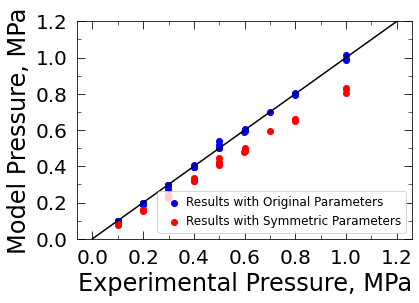

In [26]:
fig, ax = plt.subplots()

ax.plot([0.0,1.2],[0.0,1.2],color='black')

ax.scatter(data_subset['pressure']/1e6,fitted_data['P, MPa'],color='blue',label='Results with Original Parameters')
ax.scatter(data_subset['pressure']/1e6,fitted_data_symm['P, MPa'],color='red',label='Results with Symmetric Parameters')

ax.set_ylim(0,1.2)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1],minor=True)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9, 1.1],minor=True)

ax.tick_params("both", direction="in", which="both", length=4, labelsize=20, pad=10)
ax.tick_params("both", which="major", length=8)
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.set_xlabel('Experimental Pressure, MPa',fontsize=24)
ax.set_ylabel('Model Pressure, MPa',fontsize=24)
ax.legend(fontsize=12, handletextpad=0.00, loc="lower right")
# fig.savefig('125-emim-parity_results_symmetry_highPincl.png',bbox_inches='tight')